# Method to analyze whether SNV in ETS

In [1]:

import helper_functions as hf
import pandas as pd
import numpy as np
import pickle
import os
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import sigfig as sf

import statsmodels.api as sm

In [2]:
def getAll8mers(seq,p,ref,alt):
    
    altLenAdj=len(ref)-len(alt)
        
    if altLenAdj==0:
        seq=seq[p-7:p+8]    
        seqRef=seq[:7]+ref+seq[7+1:]
        seqAlt=seq[:7]+alt+seq[7+1:]
        
    elif altLenAdj>0:
        seq=seq[p-7:p+8+altLenAdj]    
        seqRef=seq[:7]+ref+seq[7+1:-altLenAdj]
        seqAlt=seq[:7]+alt+seq[7+1:]
    else:
        raise ValueError('ref/alt not allowed yet')
    
    # if len(seqRef)!=len(seqAlt):
        # raise ValueError('ref/alt seqs not dovetailed')
        
    for i,end in enumerate(range(7,len(seq)-altLenAdj)):
        start=end-7
        last=end+1
        kmer8Ref=seqRef[start:last]
        kmer8Alt=seqAlt[start:last]
            
        yield kmer8Ref,kmer8Alt
            
            

In [3]:
def ets(kmer4):
    if kmer4 in ['GGAA','GGAT','TTCC','ATCC']: return True
    else:                                      return False

# Set up logic for creating/deleting ets sites
BeforeAfter2EtsLogic={
    (0,0):'Ets Never',
    (1,1):'Ets Always',
    (0,1):'Ets Created',
    (1,0):'Ets Deleted'
}

In [4]:
def snv_ets_analysis(chrom,idx1,ref,alt,chr2seq,tf2aff):
    
    # Ensure data is snp, no indels
    prohibitedPolyTypes=['Other']
    if len(ref)==1 and len(alt)==1: 
        polymorphismType='SNV'
        
    elif len(ref)==1 and len(alt)==0:
        polymorphismType='SND'
        
    else:
        polymorphismType='Other'
        
    if polymorphismType in prohibitedPolyTypes:
        return 'Variant Type Not Allowed Yet'
        
    ######################################
    # Verify ref/alt matches genomic bp
    ######################################
    
    if 'chr' not in chrom: chrom=f'chr{chrom}'
    
    # Check if pos in genome is same as declared REF
    idx0=int(idx1)
    snvNtInGenome=chr2seq[chrom][idx0]
    if ref==snvNtInGenome:    
        checkSnv='REF'
    elif alt==snvNtInGenome:  
        checkSnv='ALT'
    else:                     
        return f'Genomic bp does not match expectation: \n  expected ref/alt = ({ref}/{alt})\n  observed = {snvNtInGenome}'
    
    
    ######################################
    # Assess if SNV is in ETS
    ######################################
    
    etsChanged=False
    for kmer8,kmer8mut in getAll8mers(chr2seq[chrom],idx0,ref,alt):
        core   =kmer8[2:6]
        coremut=kmer8mut[2:6]

        ba=(ets(core),ets(coremut)) # before after logic
        etsLogic=BeforeAfter2EtsLogic[ba]

        # If ets-changing snp found, write it out
        if etsLogic=='Ets Always': 
            etsChanged=True
            refaff=tf2aff[kmer8]
            altaff=tf2aff[kmer8mut]
            
            return polymorphismType,refaff,altaff,altaff/refaff,kmer8,kmer8mut

    if etsChanged==False:
        return 'Variant not in ETS'



# Load ref data

In [5]:
# Ets1
ref  =f'preprocessed-data/parsed_Ets1_8mers.txt'              
Seq2EtsAff  = hf.loadAff(ref)
hf.dprint(Seq2EtsAff)


# hg38
ref='/Users/joe/code/ref/genomes/human/hg38/fasta/hg38.fa'
chr2seq=hf.faLoadGenome(ref)

AAAAAAAA 0.14700431859740803


# Load MPRA data

In [6]:
fn='preprocessed-data/kvon-2020-table-muts-analyzed.tsv'
df=pd.read_csv(fn,sep='\t')

df=df.set_index('VISTAID')
df['SEQUENCE']=df['SEQUENCE'].apply(lambda s: s.upper())

zrs_seq=df.at['Hs2496','SEQUENCE']

df.head(2)

,TYPE,ZRS POSITION,ALLELES REF>ALT,SEQUENCE,LOSS,REDUCED,NORMAL,GAIN,STRONG GAIN,PVALUE LOF,PVALUE GOF,ANNOTATION
VISTAID,,,,,,,,,,,,
Hs2496,reference human,NaN,NaN,AACTTTAATGCCTATGTTTGATTTGAAGTCATAGCATAAAAGGTAA...,0,0,17,0,0,NaN,NaN,normal
Hs2496.1,human variant,105.0,C>G,AACTTTAATGCCTATGTTTGATTTGAAGTCATAGCATAAAAGGTAA...,0,0,2,3,0,1.0,0.006494,gain


In [7]:
zrs_seq

'AACTTTAATGCCTATGTTTGATTTGAAGTCATAGCATAAAAGGTAACATAAGCAACATCCTGACCAATTATCCAAACCATCCAGACATCCCTGAATGGCCAGAGCGTAGCACACGGTCTGTAGGATTAAGAGGTTAACTCCTATAACTTCAAACAAAGTGCCTGATAATAAAAGCAAAAAGTACAAAATTTTAGGTAACTTCCTTTCTTAATTAATTGGACTGACCAGGTGGAAGCGAAGAGTTCTGTGCTGGTGCTTGGAATGTCTATAAAGCTGAGCAACATGACAGCACAATAGAGGAGGAACAAAGATTTTTTTAATATGTTTCTATCCTGTGTCACAGTTTGAAATTGTCCTGGTTTATGTCCCTTTTGGCAAACTTACATAAAAGTGACCTTGTACTGTATTTTATGACCAGATGACTTTTTCCCCCCAGTGGCTAATTTGTATCAGGCCTCCATCTTAAAGAGACACAGAGTGAGTAGGAAGTCCAGCCTCTGTCTCCACGAGCTTTCATTGCATTCTTTCATTATTTTTGCTCGTTTTTTGCCACTGATGATCCATAAATTGTTGGAAATGAGTGATTAAGGAAGTGCTGCTTAGTGTTAGTGGCACATGCGCATATTTGGCCTGGTTCTGGTGGGTGAGAGGAAATCACAGACAAAAGGGAAGCCCCTGCTGGGAACCCTGCAAGGAAATTTAACTTGGGTCATGTTTTGATCTTAGTGTTTATTACAGAAAATGAAGCCATATCTCACTAACTATTGTTACGTGTTAATTTGATTTTCC'

In [8]:
# method to get ets starts in a sequence
def get_ets_starts(seq):
    starts=[]
    for i,kmer in enumerate(hf.get_kmers(seq,8)):
        
        # if core is ets
        if ets(kmer[2:6]):
            starts.append(i)
            
    return set(starts)
            


In [9]:
# method to determine which bases arer in an ets
def get_ets_bps(seq):
    starts=[]
    bp2start={}
    start2bp={}
    for i,kmer in enumerate(hf.get_kmers(seq,8)):
        
        # if core is ets
        if ets(kmer[2:6]):
            start2bp[i]=set()
            for j in range(i,i+8):
                starts.append(j)
                start2bp[i].add(j)
                bp2start[j]=i
            
    return set(starts),bp2start,start2bp



In [10]:
def get_mismaches(seq,altseq):
    if len(seq)!=len(altseq):
        raise ValueError('length mismatch')
        
    mismatches=[]
    for i,(ref,alt) in enumerate(zip(seq,altseq)):
        
        if ref!=alt:
            mismatches.append(i)
            
    return set(mismatches)
         
altseq=df.at['Hs2496.75','SEQUENCE']


In [11]:

zrsEtsBases,zrsBp2Start,zrsStart2Bp =get_ets_bps(zrs_seq)
zrsEtsStarts=get_ets_starts(zrs_seq)

zrsStart2Aff={zrsStart : Seq2EtsAff[ zrs_seq[ zrsStart:zrsStart+8 ] ] for zrsStart in zrsStart2Bp}

In [12]:
Anno2Effect={'normal':0, 'gain':1, 'strong gain':1, 'reduced':-1, 'loss':-1}

In [13]:
# only consider 2percent muts
df=df.loc[df['TYPE']=='2percent']
    

df['PVALUE LOF']=sm.stats.multipletests(df['PVALUE LOF'],method='fdr_bh')[1]
df['PVALUE GOF']=sm.stats.multipletests(df['PVALUE GOF'],method='fdr_bh')[1]
    
df.head()

,TYPE,ZRS POSITION,ALLELES REF>ALT,SEQUENCE,LOSS,REDUCED,NORMAL,GAIN,STRONG GAIN,PVALUE LOF,PVALUE GOF,ANNOTATION
VISTAID,,,,,,,,,,,,
Hs2496.65,2percent,NaN,NaN,AACTTTAATGCCTATGTTTGATTTGAAGTCATAGCATAAAAGGTAA...,0,4,0,0,0,0.001093,1.000000,reduced
Hs2496.66,2percent,NaN,NaN,AACTTTAATGCCTATGTTCGATTTGAAGTCATAGCATAAAAGGTAA...,1,0,2,0,0,0.189706,1.000000,normal
Hs2496.67,2percent,NaN,NaN,AACATTAATGCCTATGTTTGATTTGAAGTCATAGCATAAATGGTAA...,0,0,3,0,0,1.000000,1.000000,normal
Hs2496.68,2percent,NaN,NaN,AACTTTAATGCCTCAGTTTGATTGGAAGTTATAGCATAAAAGGTAA...,0,0,2,0,0,1.000000,1.000000,normal
Hs2496.69,2percent,NaN,NaN,AACTTTAATGCCTATGTTTGATTTGAAGTCATAGCATAAAAGGTAA...,0,0,2,5,2,1.000000,0.002365,gain


In [14]:
enList=[]
pvalueList=[]
effectList=[]
variantTypeList=[] # Not In Ets, delete,decrease,increase,de novoo
refAffList=[]
altAffList=[]
fcList=[]
ref8merlist=[]
alt8merlist=[]
groupList=[]

seqTestedList=[]

for idx in df.index:
    
    group=df.at[idx,'TYPE']
    
    # only consider the 2percent class
    if group not in ['2percent']: continue
    
    anno=df.at[idx,'ANNOTATION']
    seqalt=df.at[idx,'SEQUENCE']
    
    effect=Anno2Effect[anno]
    if   effect>0: pval=df.at[idx,'PVALUE GOF']
    elif effect<0: pval=df.at[idx,'PVALUE LOF']
    else:          pval=1
    
    # determine mismatches
    mismatchSet=get_mismaches(zrs_seq,seqalt)
    
    # determine which bases are ets & starts of ets
    altEtsBases,altBp2Start,altStart2Bp  = get_ets_bps(seqalt)
    altEtsStarts = get_ets_starts(seqalt)
    
    # determine denovo ets bass
    denovoEtsBases = altEtsBases - zrsEtsBases
    denovoEtsstarts = altEtsStarts - zrsEtsStarts
    
    # determine deleted bases
    deletedEtsBases = zrsEtsBases - altEtsBases
    deletedetsStarts = zrsEtsStarts - altEtsStarts
    
    # iterate over all ets sites
    allEtsStarts = altEtsStarts | zrsEtsStarts
    for etsStart in allEtsStarts:
        
        # de novo 
        if etsStart in denovoEtsstarts:
            variantTypeList.append('De Novo Ets')
            refAffList.append('')
            altAffList.append('')
            fcList.append('')
            ref8merlist.append('')
            alt8merlist.append('')
            effectList.append(effect)
            pvalueList.append(pval)
            groupList.append(group)
            enList.append(idx)
            seqTestedList.append(seqalt)
            
        # deleted
        elif etsStart in deletedetsStarts:
            variantTypeList.append('Deleted Ets')
            refAffList.append('')
            altAffList.append('')
            fcList.append('')
            ref8merlist.append('')
            alt8merlist.append('')
            effectList.append(effect)
            pvalueList.append(pval)
            groupList.append(group)
            enList.append(idx)
            seqTestedList.append(seqalt)
            
        # decreased, increased
        else:
            
            ref8mer=zrs_seq[etsStart:etsStart+8]
            alt8mer=seqalt [etsStart:etsStart+8]
            
            refaff=Seq2EtsAff[ref8mer]
            altaff=Seq2EtsAff[alt8mer]
            fc=altaff/refaff
            
            if fc<=1: variantTypeList.append('Decrease Ets Aff')
            else:     variantTypeList.append('Increase Ets Aff')
            
            refAffList.append(refaff)
            altAffList.append(altaff)
            fcList.append(fc)
            ref8merlist.append(ref8mer)
            alt8merlist.append(alt8mer)
            effectList.append(effect)
            pvalueList.append(pval)
            groupList.append(group)
            enList.append(idx)
            seqTestedList.append(seqalt)
           
    # iterate over all non ets siter
    nonEtsChanges = mismatchSet - altEtsBases - zrsEtsBases
    for nonEts in nonEtsChanges:
        variantTypeList.append('Not in Ets')
        refAffList.append('')
        altAffList.append('')
        fcList.append('')
        ref8merlist.append('')
        alt8merlist.append('')
        effectList.append(effect)
        pvalueList.append(pval)
        groupList.append(group)
        enList.append(idx)
        seqTestedList.append(seqalt)
        
    # break
            
c2v={'p-value':pvalueList,
'effect':effectList,
'variant-type':variantTypeList,
'aff-ref':refAffList,
'aff-alt':altAffList,
'aff-fc':fcList,
'kmer-ref':ref8merlist,
'kmer-alt':alt8merlist,
'group':groupList,
'en':enList,
'seq-tested':seqTestedList}

In [15]:
df=pd.DataFrame(c2v)



df['-log(p)']=df['p-value'].apply(lambda p: -np.log10(p) if p<1 else 0)
df['-log(p)*direction']=df.apply(lambda r: r['-log(p)'] if r['effect']>=0 else -r['-log(p)'],axis=1)

In [16]:
df['variant-type'].value_counts()

Decrease Ets Aff    731
Not in Ets          535
Deleted Ets          58
Increase Ets Aff     28
De Novo Ets          21
Name: variant-type, dtype: int64

In [17]:
df.to_csv('FOR-NATURE-ALL-DATA-kvon-corrected-pvals.tsv',sep='\t',index=None)

# Begin plotting

In [18]:
plotDF=df

In [19]:
logSigCutoff=-np.log10(.05)


all other vs increase ets:  p=0.0311


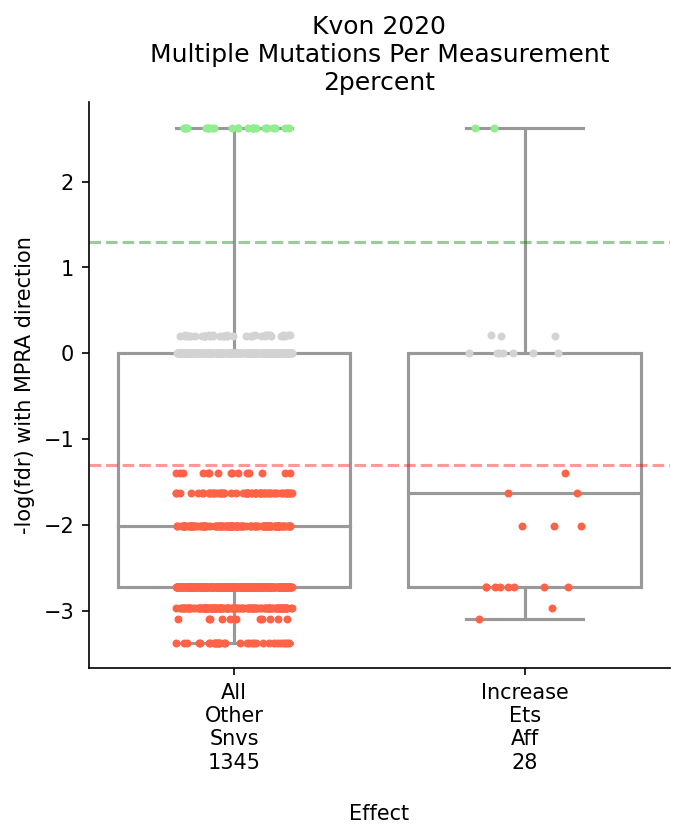

In [20]:
gi='2percent'

tempDF=plotDF.loc[plotDF['group']==gi,:]

############################################################
# Get Data
############################################################

xticklabels=['All Other Snvs','Increase Ets Aff']

#           d0           d1            d2                 d3                 d4    
dataLabels=['Not in Ets','Deleted Ets','Decrease Ets Aff','Increase Ets Aff','De Novo Ets']
d1,d2,d3,d4=[(tempDF['variant-type']==di) for di in dataLabels[1:]]
d0=(df['variant-type']==dataLabels[0])

D0=df.loc[d0,'-log(p)*direction'].replace([np.inf,-np.inf],np.NaN).dropna().tolist()
D1,D2,D3,D4=[tempDF.loc[di,'-log(p)*direction'].replace([np.inf,-np.inf],np.NaN).dropna().tolist() for di in [d1,d2,d3,d4]]

data=[D0+D1+D2+D4,D3]

############################################################
# Plots
############################################################

fig,ax=plt.subplots(1,figsize=(5,5),dpi=150)

plotType='box' # box or violin

colors=['lightgrey','red','tomato','lightgreen','green']
if plotType=='violin':



    sns.violinplot(data=data,ax=ax,color='white',cut=0,width=.5,inner=None,scale='width') 

    for i,(d,ci) in enumerate(zip(data,colors)):
        y=np.mean(d)
        print(i,y)
        ax.plot([i-.3,i+.3],[y,y],color=ci)

for xi,di in enumerate(data):
    for lc, yi in enumerate(di):
        if lc>1000: break
        xjittermax=.2
        xijitter=np.random.uniform(-xjittermax,xjittermax)
        if yi>=logSigCutoff:            color='lightgreen'
        elif yi<=-logSigCutoff:          color='tomato'
        else:                           color='lightgrey'

        ax.scatter(xijitter+xi,yi, color=color,s=8,zorder=100,alpha=1)#,cut=0) 

if plotType=='box':

    sns.boxplot(data=data,ax=ax,color='white',width=.8,fliersize=0)     

ax.set_title(f'Kvon 2020\nMultiple Mutations Per Measurement\n{gi}')

ax.set_xticklabels([dl.replace(' ','\n')+f'\n{len(di)}' for dl,di in zip(xticklabels,data)])
ax.set_ylabel('-log(fdr) with MPRA direction')
ax.set_xlabel('\nEffect')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.set_ylim(-6.5,9)

############################################################
# Do Stats
############################################################

_,p=stats.mannwhitneyu(data[0],data[1],alternative='less')

print(f'all other vs increase ets:  p={sf.round(p,3)}')

############################################################
# add indicator of significance
############################################################
xmin=-.5
xmax=1.5

ax.axhline(logSigCutoff,color='green',ls='--',alpha=.4)
ax.axhline(-logSigCutoff,color='red',ls='--',alpha=.4)

ax.set_xlim(xmin,xmax)

plt.show()